<a href="https://colab.research.google.com/github/OhJin-Soo/ktb_ai/blob/main/data_augmented_almond_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mahyeks_almond_varieties_path = kagglehub.dataset_download('mahyeks/almond-varieties')

print('Data source import complete.')

Using Colab cache for faster access to the 'almond-varieties' dataset.
Data source import complete.


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import os

import tensorflow as tf
from tensorflow import keras

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
IMG_SIZE = 224

In [11]:
def create_data(base_dir):
    x = []
    y = []
    index_label = dict()
    label_index = dict()

    for i, j in enumerate(os.listdir(base_dir)):
        label = os.path.join(base_dir, j)
        index_label[i] = j
        label_index[j] = i
        for k in os.listdir(label):
            im_path = os.path.join(label, k)
            image = cv2.imread(im_path)
            image = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
            x.append(image)
            y.append(i)

    x = np.array(x)
    y = np.array(y)
    x = x/255.0
    y = keras.utils.to_categorical(y, len(index_label))
    return x, y, label_index, index_label

In [12]:
base_dir = "/kaggle/input/almond-varieties/dataset"

In [14]:
x, y, label_index, index_label = create_data(base_dir)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [16]:
resnet = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),          # 좌우 반전
    keras.layers.RandomRotation(0.08),              # 회전 (약 ±8%)
    keras.layers.RandomTranslation(0.1, 0.1),       # 좌표 이동 (10%)
    keras.layers.RandomZoom(0.08),                  # 확대/축소
    # keras.layers.RandomContrast(0.1),             # 필요하면 추가
], name="data_augmentation")

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)    # 여기서만 증강 적용
x = resnet(x, training=True)     # pretrained base model이라고 가정
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1000, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(len(index_label), activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# fit (x_train, y_train) 직접 사용 — 증강은 모델 내부에서 적용됨
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[
        keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    ]
)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6320 - loss: 20.7174

39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 403ms/step - accuracy: 0.6357 - loss: 20.3972 - val_accuracy: 0.2340 - val_loss: 62513376.0000
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.8960 - loss: 0.8309 - val_accuracy: 0.2340 - val_loss: 101093360.0000
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.8294 - loss: 1.0630 - val_accuracy: 0.2340 - val_loss: 398677.4375
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8964 - loss: 1.2047

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.8963 - loss: 1.1920 - val_accuracy: 0.2628 - val_loss: 7.7621
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9120 - loss: 0.4443 - val_accuracy: 0.2628 - val_loss: 5.3825
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9393 - loss: 0.2229 - val_accuracy: 0.2628 - val_loss: 8.6245
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9242 - loss: 0.9908 - val_accuracy: 0.2628 - val_loss: 9.7260
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9267 - loss: 0.2029 - val_accuracy: 0.2628 - val_loss: 12.2172
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9440 - loss: 0.1862 - val_accuracy: 0.2628 - val_loss: 8.1130
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9397 - loss: 0.1680 - val_accuracy: 0.2628 - val_loss: 5.3012
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9484 - loss: 0.1403 - val_accuracy: 0.2628 - v

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.9666 - loss: 0.1078 - val_accuracy: 0.2692 - val_loss: 2.1793
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9567 - loss: 0.1105 - val_accuracy: 0.2628 - val_loss: 6.6483
Epoch 16/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9880 - loss: 0.0449

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9879 - loss: 0.0450 - val_accuracy: 0.2853 - val_loss: 2.0447
Epoch 17/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9833 - loss: 0.0609 - val_accuracy: 0.2628 - val_loss: 7.6889
Epoch 18/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9835 - loss: 0.0509 - val_accuracy: 0.2628 - val_loss: 11.2066
Epoch 19/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9666 - loss: 0.0860 - val_accuracy: 0.2628 - val_loss: 10.6851
Epoch 20/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9844 - loss: 0.0464 - val_accuracy: 0.2628 - val_loss: 12.2556
Epoch 21/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9867 - loss: 0.0473 - val_accuracy: 0.2308 - val_loss: 3.5676
Epoch 22/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9839 - loss: 0.0602 - val_accuracy: 0.2628 - val_loss: 11.6063


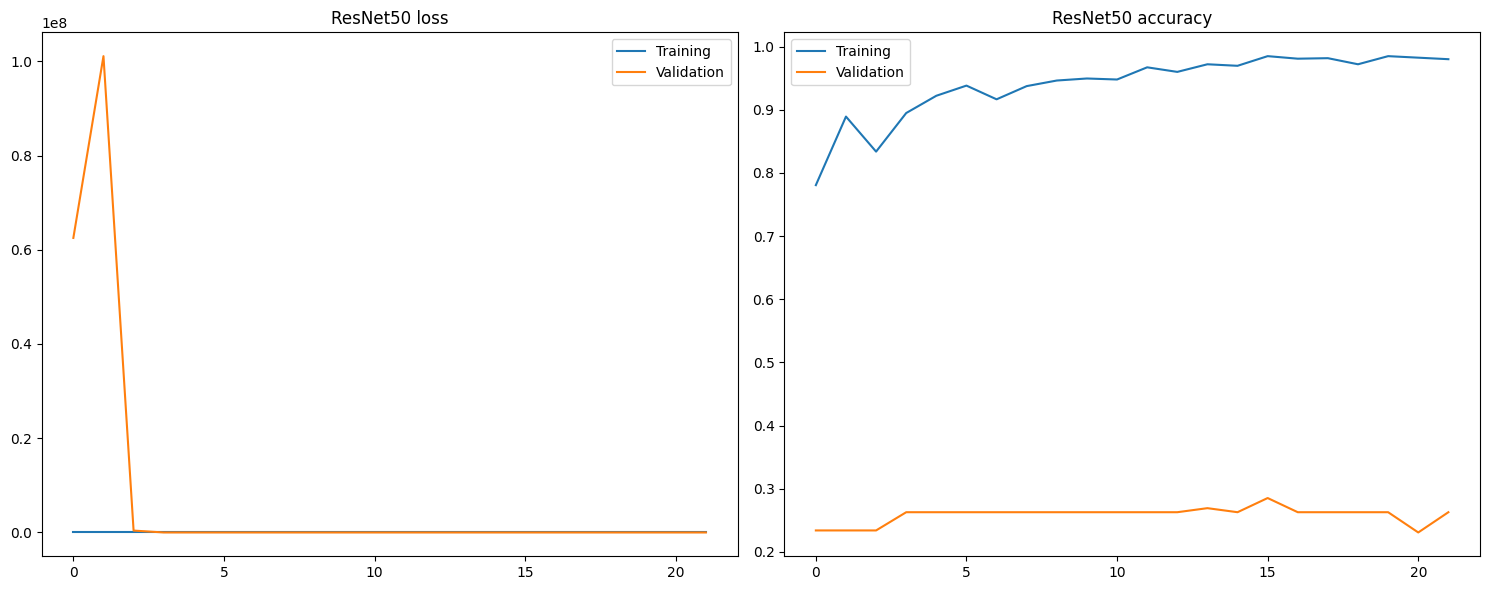

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(history.history["loss"], label="Training")
axes[index].plot(history.history["val_loss"], label="Validation")
axes[index].set_title("ResNet50 loss")
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].legend()

index += 1

axes[index].plot(history.history["accuracy"], label="Training")
axes[index].plot(history.history["val_accuracy"], label="Validation")
axes[index].set_title("ResNet50 accuracy")
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].legend()

plt.tight_layout()
plt.show()

In [19]:
def predict(img):
    label = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))
    pred = label.argmax()
    return pred, label[0][pred], index_label[pred]

In [20]:
truth = []
predicted = []
probabilities = []
labels = []

for i in range(x_test.shape[0]):
    img_arr = x_test[i]
    truth += [y_test[i].argmax()]
    pred, prob, label = predict(img_arr)
    predicted += [pred]
    probabilities += [prob]
    labels += [label]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

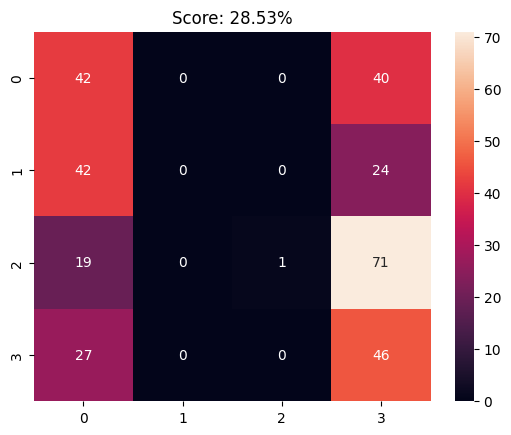

              precision    recall  f1-score   support

           0       0.32      0.51      0.40        82
           1       0.00      0.00      0.00        66
           2       1.00      0.01      0.02        91
           3       0.25      0.63      0.36        73

    accuracy                           0.29       312
   macro avg       0.39      0.29      0.20       312
weighted avg       0.44      0.29      0.20       312



In [21]:
score = accuracy_score(truth, predicted)
cm = confusion_matrix(truth, predicted)
report = classification_report(truth, predicted)
sns.heatmap(cm, annot=True)
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()
print(report)

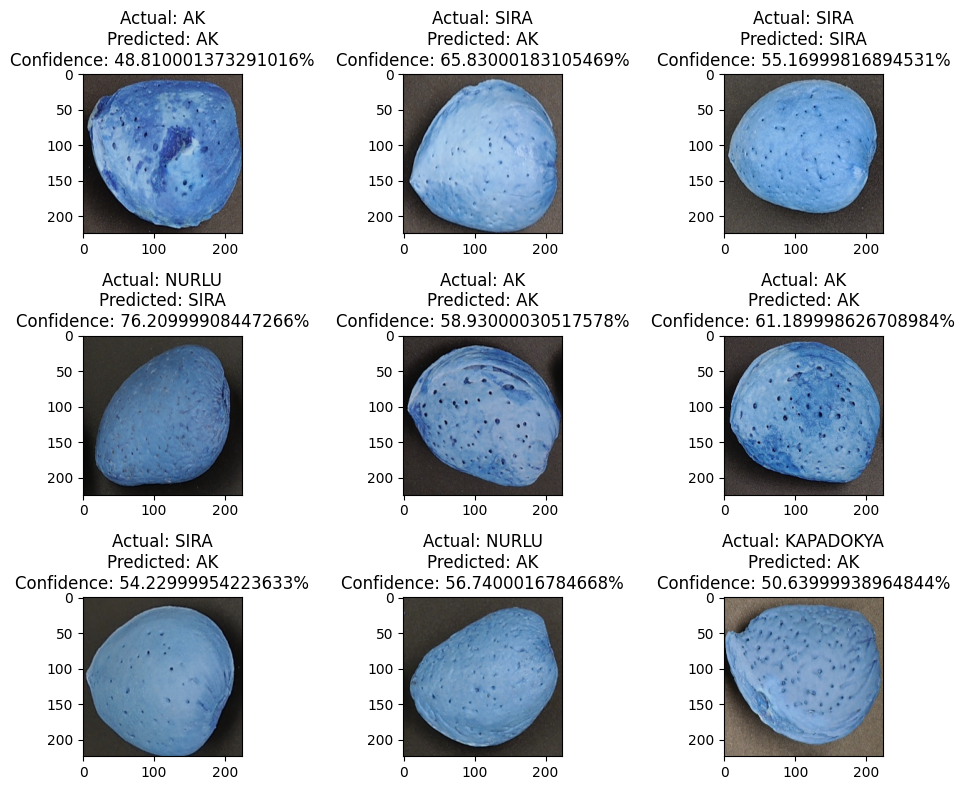

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
index = 0

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(x_test[index])
        axes[i][j].set_title("Actual: {}\nPredicted: {}\nConfidence: {}%".format(index_label[truth[index]],
                                                                                labels[index],
                                                                                round(probabilities[index]*100, 2)))
        index += 1
plt.tight_layout()
plt.show()